# Basic diagnostics to roughly asses model performance of full forcing run
## Large scale circulation

In [2]:
#import bunch of packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src/visualization/' directory as one where we can import modules
vis_dir = os.path.join(os.pardir,'src','visualization','')
sys.path.append(vis_dir)

# import my methods, make sure they get reloded by each call
%aimport plot_barotropic
from plot_barotropic import plot_avg_uvbar_ssh
%aimport plot_dpt
from plot_dpt import plot_timeseries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Large domain annual average barotropic currents and sea surface height
Derived from monthly averages of the last year of integration (year 5)

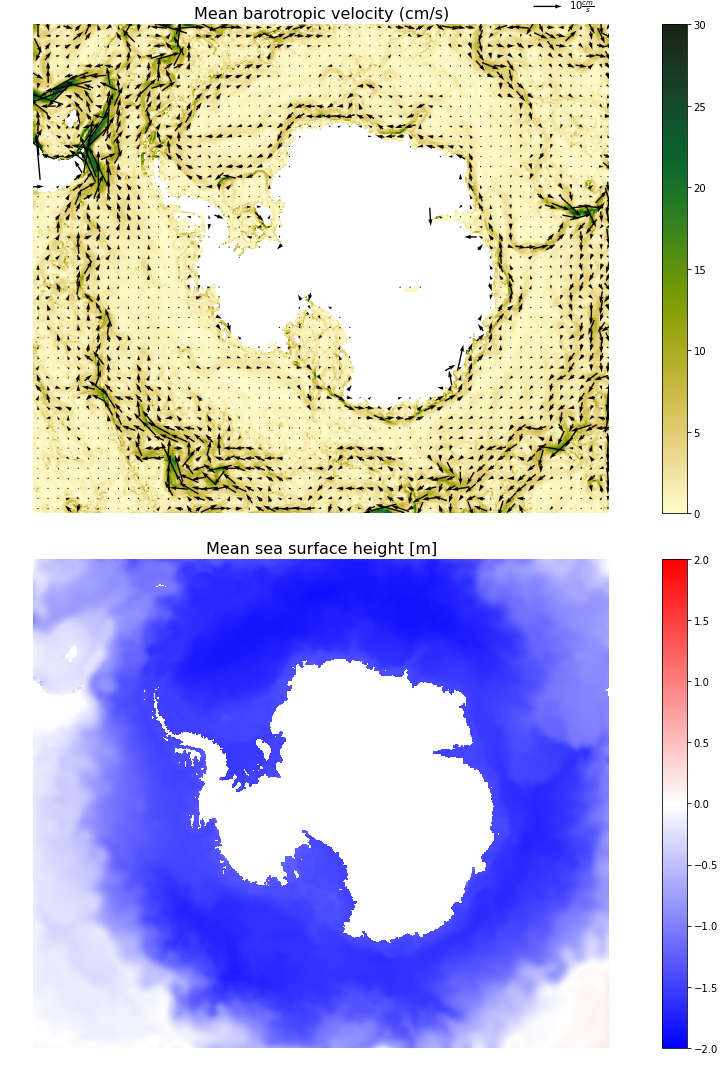

In [10]:
raw_dir = os.path.join(os.pardir,'data','raw')
avg_5yr_file =  os.path.join(raw_dir,'waom10_full_forcing','ocean_avg_0005.nc')
plot_avg_uvbar_ssh(avg_5yr_file,0,11)

... looks very good. No artificial boundary currents and the large scale pattern of the ACC seems to be ok.

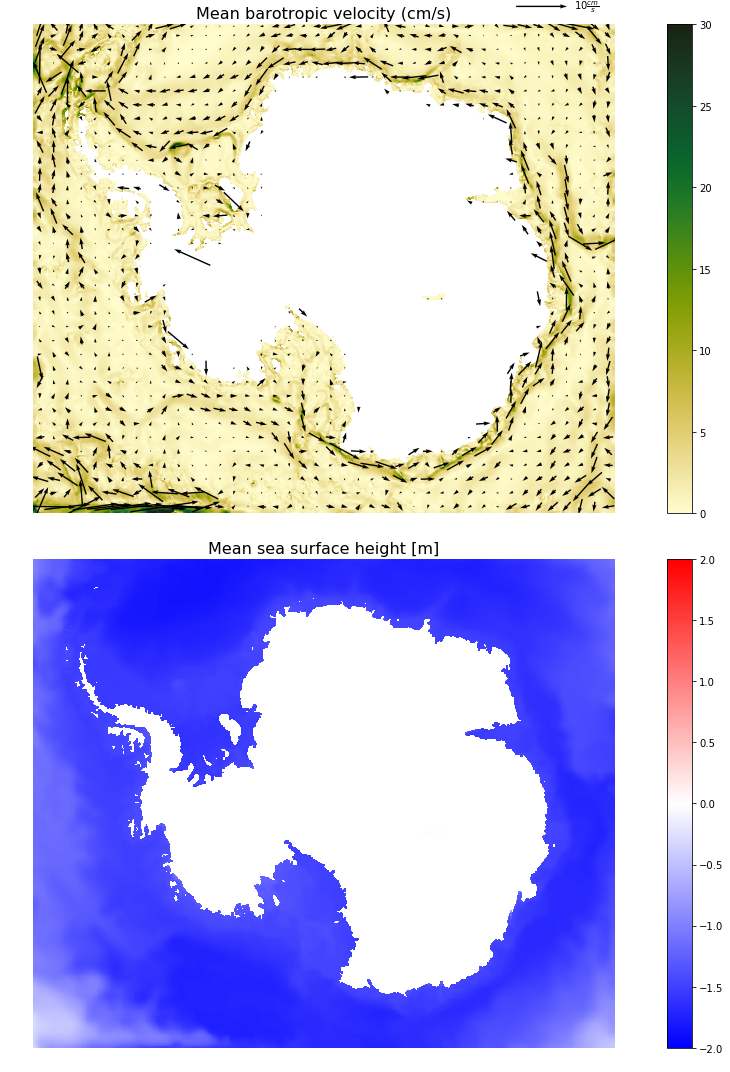

In [11]:
avg_5yr_small_file = os.path.join(raw_dir,'waom10_small_domain','ocean_avg_0005.nc')
plot_avg_uvbar_ssh(avg_5yr_small_file,0,11)

... resembles the pattern of the large domain, but we've got this nasty artifical boundary currents in the bottom left corner. Therefore I proceed with the large domain.  

### Drake passage transport

In [17]:
avg_5yrs_file = os.path.join(raw_dir,'waom10_full_forcing','ocean_avg_0001-0005.nc')
plot_dpt.plot_timeseries(avg_5yrs_file)

AttributeError: 'function' object has no attribute 'plot_timeseries'

## Tides
### Hourly snapshots covering one day of barotropic circulation and sea surface height
Full forcing two years spin up without tides, then activating tides without ramping and writing hourly output for 14 days. Plots below show hourly snapshots of day 14.

In [17]:
path_l_hourly = '../data/raw/waom10_POT10/ocean_his_hourly_0005.nc'
uv_vectorplot.plot_widget(path_l_hourly,341,365)

read in the data
initialize and fill up the arrays


### Compare amplitudes and phases in weddell, ross, bellinghausen and davis sea against ATG-Database

In [229]:
import ttide as tt
import numpy as np
import extract_zeta as ez
import imp
imp.reload(ez)
import scipy.io as sio

def read_atg(path_atgmat,site_id):
    mat_content = sio.loadmat(atg_path)
    atg_data = mat_content['atg']
    tide_data = {}
    for key in ['name','lat','lon','amp','Gphase']:
        tide_data[key] =np.squeeze(atg_data[key][0,0][site_id-1])
        tide_data['constit']=np.squeeze(atg_data['constit'][0,0][:])
    tide_data['name'] = tide_data['name'].strip()
    return tide_data

In [255]:
path_atg = '../data/atg/ATG_ocean_height_2010_0908.mat'

tide_davis={}
tide_weddell = {}
tide_bellinghausen = {}
tide_ross = {}

tide_davis['area']="Davis sea"
tide_weddell['area']='Weddell sea'
tide_bellinghausen['area']='Bellinghausen Sea'
tide_ross['area']='Ross sea'

tide_davis['atg']=read_atg(path_atg,24)
tide_weddell['atg']=read_atg(atg_path,42)
tide_bellinghausen['atg'] = read_atg(atg_path,84)
tide_ross['atg'] = read_atg(atg_path,79)

tide_davis['roms_signal']=ez.extractZeta(path_l_hourly,tide_davis['atg']['lat'],tide_davis['atg']['lon'])
tide_weddell['roms_signal']=ez.extractZeta(path_l_hourly,tide_weddell['atg']['lat'],tide_weddell['atg']['lon'])
tide_bellinghausen['roms_signal']=ez.extractZeta(path_l_hourly,tide_bellinghausen['atg']['lat'],tide_bellinghausen['atg']['lon'])
tide_ross['roms_signal']=ez.extractZeta(path_l_hourly,tide_ross['atg']['lat'],tide_ross['atg']['lon'])

extract zeta ...
target lat, lon:  -68.45 77.967
nearest neighbour lat, lon:  -68.5117837548 78.0238675456
extract zeta ...
target lat, lon:  -76.583 -32.01
nearest neighbour lat, lon:  -76.4996376017 -31.9641632258
extract zeta ...
target lat, lon:  -66.75 -70.9998
nearest neighbour lat, lon:  -66.7644591858 -71.0693027774
extract zeta ...
target lat, lon:  -74.75 164.0
nearest neighbour lat, lon:  -74.8513677946 163.864411317


In [256]:
import datetime
  
tide_davis['t_tide']={}
tide_weddell['t_tide'] = {}
tide_bellinghausen['t_tide'] = {}
tide_ross['t_tide'] = {} 

tide_davis['t_tide']['raw']=tt.t_tide(tide_davis['roms_signal'],dt=1,stime=datetime.datetime(1984,8,1),lat=tide_davis['atg']['lat'],out_style=None)
tide_weddell['t_tide']['raw']=tt.t_tide(tide_weddell['roms_signal'],dt=1,stime=datetime.datetime(1984,8,1),lat=tide_weddell['atg']['lat'],out_style=None)
tide_bellinghausen['t_tide']['raw']=tt.t_tide(tide_bellinghausen['roms_signal'],dt=1,stime=datetime.datetime(1984,8,1),lat=tide_bellinghausen['atg']['lat'],out_style=None)
tide_ross['t_tide']['raw']=tt.t_tide(tide_ross['roms_signal'],dt=1,stime=datetime.datetime(1984,8,1),lat=tide_ross['atg']['lat'],out_style=None)

In [257]:
for sea in [tide_davis,tide_ross,tide_bellinghausen,tide_weddell]:
    sea['t_tide']['keys']=['amp','amp_err','Gphase','phase_err']
    for ind,con_bstr in enumerate(sea['t_tide']['raw']['nameu']):
        con_str = con_bstr.decode('UTF-8').strip()
        sea['t_tide'][con_str]=sea['t_tide']['raw']['tidecon'][ind]
        
    for ind,value in enumerate(sea['atg']['constit']):
        m2cm = 1.0/100.0
        amp = sea['atg']['amp'][ind]*m2cm
        Gphase = sea['atg']['Gphase'][ind]
        sea['atg'][value]=[amp,None,Gphase,None]
    del sea['atg']['Gphase']
    del sea['atg']['amp']

In [259]:
for sea in [tide_davis,tide_weddell,tide_bellinghausen,tide_ross]:
    print(sea['area'],' Station: ',sea['atg']['name'])
    print("Amp[m]:  atg   roms || Gphase[deg]:  atg     roms")
    for con in ['M2','S2','O1','K1']:
        print(con,":     %0.2f"%sea['atg'][con][0], " %0.2f"%sea['t_tide'][con][0],\
             '                 %0.2f'%sea['atg'][con][2]," %0.2f"%sea['t_tide'][con][2])

Davis sea  Station:  20100- Davis
Amp[m]:  atg   roms || Gphase[deg]:  atg     roms
M2 :     0.20  0.86                  208.51  196.40
S2 :     0.18  0.76                  307.09  303.27
O1 :     0.29  0.23                  269.02  287.09
K1 :     0.28  0.28                  276.98  108.23
Weddell sea  Station:  ROPEX M2
Amp[m]:  atg   roms || Gphase[deg]:  atg     roms
M2 :     0.77  1.79                  247.71  171.68
S2 :     0.52  1.11                  269.32  267.53
O1 :     0.32  0.18                  5.21  4.32
K1 :     0.32  0.07                  11.86  141.98
Bellinghausen Sea  Station:  Marguerite Bay A3
Amp[m]:  atg   roms || Gphase[deg]:  atg     roms
M2 :     0.12  0.81                  262.23  353.62
S2 :     0.14  0.66                  64.05  90.53
O1 :     0.25  0.15                  70.00  75.89
K1 :     0.29  0.16                  87.91  213.08
Ross sea  Station:  Terra Nova Bay Tide Gauge
Amp[m]:  atg   roms || Gphase[deg]:  atg     roms
M2 :     0.07  0.51        

## Stratification
### SST and SSS monthly evolution roms_avg vs. sose_clim

In [18]:
from sys import path
path.append('../data/external/sose/.')
import mds
import scipy.io as sio
import numpy as np

path_sst_sose = '../data/external/sose/THETA_mnthlyBar'
path_sss_sose = '../data/external/sose/SALT_mnthlyBar'
path_sose_grid = '../data/external/sose/grid.mat'
sst_sose_raw = mds.rdmds(path_sst_sose,itrs=np.NaN,returnmeta=True,lev=[0],fill_value=np.NaN)
sss_sose_raw = mds.rdmds(path_sss_sose,itrs=np.NaN,returnmeta=True,lev=[0],fill_value=np.NaN)
grid_sose = sio.loadmat(path_sose_grid)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [19]:
sst_sose_clim =np.mean(np.reshape(sst_sose_raw[0],(6,12,320,2160)),axis=0)
sss_sose_clim =np.mean(np.reshape(sss_sose_raw[0],(6,12,320,2160)),axis=0)

In [20]:
mask_sose_raw = grid_sose["maskCtrlC"]
mask_sose = np.tile(np.swapaxes(mask_sose_raw[:,:,0],0,1),(12,1,1))
sst_sose_clim_masked = np.ma.masked_where(mask_sose==0.0,sst_sose_clim)
sss_sose_clim_masked = np.ma.masked_where(mask_sose==0.0,sss_sose_clim)

In [21]:
from scipy.interpolate import RegularGridInterpolator
from netCDF4 import Dataset
id = Dataset(path_l_avg,'r')
sst_roms = id.variables["temp"][:,30,:,:]
sss_roms = id.variables["salt"][:,30,:,:]
lat_roms = id.variables['lat_rho'][:,:]
lon_roms = id.variables['lon_rho'][:,:]
id.close()

sst_sose_rg = np.ma.zeros((12,np.size(lat_roms,0),np.size(lat_roms,1)))
sss_sose_rg = np.ma.zeros((12,np.size(lat_roms,0),np.size(lat_roms,1)))
lon_sose_raw = grid_sose["XC"][:,0]
lon_sose_raw[lon_sose_raw>180] -=360
order = np.argsort(lon_sose_raw)
lon_sose = lon_sose_raw[order]
lat_sose = grid_sose["YC"][0,:]
print('Interpolating sst ...')
for month,sst in enumerate(sst_sose_clim_masked):
    data_sose = sst[:,order]
    interp_func = RegularGridInterpolator((lat_sose,lon_sose),data_sose,bounds_error=False, method="nearest",fill_value=0.0)
    sst_sose_rg[month] = interp_func((lat_roms,lon_roms))
sst_sose_rg.mask[sst_sose_rg.data==0.0] = True
print('Interpolating sss ...')
for month,sss in enumerate(sss_sose_clim_masked):
    data_sose = sss[:,order]
    interp_func = RegularGridInterpolator((lat_sose,lon_sose),data_sose,bounds_error=False, method="nearest",fill_value=0.0)
    sss_sose_rg[month] = interp_func((lat_roms,lon_roms))
sss_sose_rg.mask[sss_sose_rg.data==0.0] = True

Interpolating sst ...


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2461: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[out_of_bounds] = self.fill_value


Interpolating sss ...


In [22]:
sst_diff = sst_roms - sst_sose_rg
sss_diff = sss_roms - sss_sose_rg

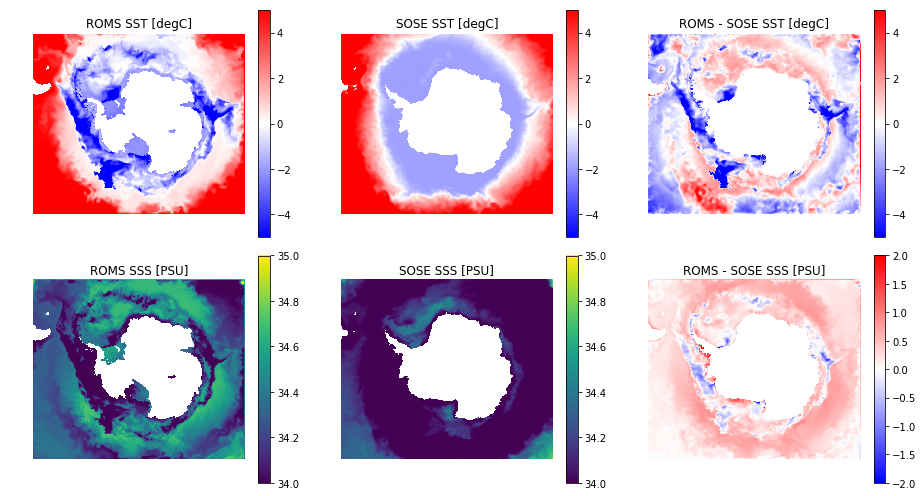

<function __main__.plot>

In [23]:
from ipywidgets import interact
import matplotlib.pyplot as plt

def plot(month):
    
    fig,axes = plt.subplots(2,3,figsize=(13,7))
    
    rsst= axes[0,0].pcolormesh(sst_roms[month],vmin=-5,vmax=5,cmap=plt.cm.bwr)
    axes[0,0].set_title("ROMS SST [degC]",fontsize=12)
    plt.colorbar(rsst,ax=axes[0,0])
    axes[0,0].set_aspect('equal')
    axes[0,0].axis('off')

    ssst = axes[0,1].pcolormesh(sst_sose_rg[month],vmin=-5,vmax=5,cmap=plt.cm.bwr)
    axes[0,1].set_title("SOSE SST [degC]",fontsize=12)
    plt.colorbar(ssst,ax=axes[0,1])
    axes[0,1].set_aspect('equal')
    axes[0,1].axis('off')
    
    dsst = axes[0,2].pcolormesh(sst_diff[month],vmin=-5,vmax=5,cmap=plt.cm.bwr)
    axes[0,2].set_title("ROMS - SOSE SST [degC]",fontsize=12)
    plt.colorbar(dsst,ax=axes[0,2])
    axes[0,2].set_aspect('equal')
    axes[0,2].axis('off')
    
    rsss= axes[1,0].pcolormesh(sss_roms[month],vmin=34,vmax=35)
    axes[1,0].set_title("ROMS SSS [PSU]",fontsize=12)
    plt.colorbar(rsss,ax=axes[1,0])
    axes[1,0].set_aspect('equal')
    axes[1,0].axis('off')
    
    ssss = axes[1,1].pcolormesh(sss_sose_rg[month],vmin=34,vmax=35)
    axes[1,1].set_title("SOSE SSS [PSU]",fontsize=12)
    plt.colorbar(ssss,ax=axes[1,1])
    axes[1,1].set_aspect('equal')
    axes[1,1].axis('off')
    
    dsss = axes[1,2].pcolormesh(sss_diff[month],vmin=-2,vmax=2,cmap=plt.cm.bwr)
    axes[1,2].set_title("ROMS - SOSE SSS [PSU]",fontsize=12)
    plt.colorbar(dsss,ax=axes[1,2])
    axes[1,2].set_aspect('equal')
    axes[1,2].axis('off')

    plt.tight_layout()
    
    plt.show()
        
interact(plot,month=(0,11))

### Vertical transsects of year averaged temperature and salinity

In [48]:
# load roms, calculate depths and append to dataset
import calc_z
import plot_vslice
%aimport plot_vslice
path_l_avg = '../data/raw/waom10_POT10/ocean_avg_0005.nc'
ds = xr.open_dataset(path_l_avg)

z=np.empty(ds.temp.shape)
for step in np.arange(ds.ocean_time.size):
    z[step],s,C = calc_z.calc_z(ds.h.values,ds.zice[step].values,ds.theta_s.values,ds.theta_b.values,ds.hc.values,31,ds.zeta[step].values)
ds['temp']=ds.temp.assign_coords(depth=xr.DataArray(z,dims=['ocean_time','s_rho','eta_rho','xi_rho']))

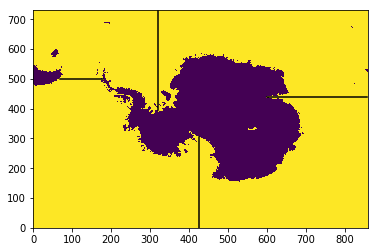

In [45]:
plt.pcolormesh(ds.mask_rho)

#linescodeline = [k_min,k_max,i_min,j_min,i_max,j_max]
amery=[0,-1,600,440,859,440,"amery"]
ross=[0,-1,427,0,427,305,"ross"]
weddell=[0,-1,320,395,320,729,"weddel"]
drake=[0,-1,70,500,180,500,"drake"]

for line in [amery,ross,weddell,drake]:
    plt.plot((line[2],line[4]),(line[3],line[5]),"k-")
plt.show()

In [49]:
plot_vslice.plot_vslice?

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


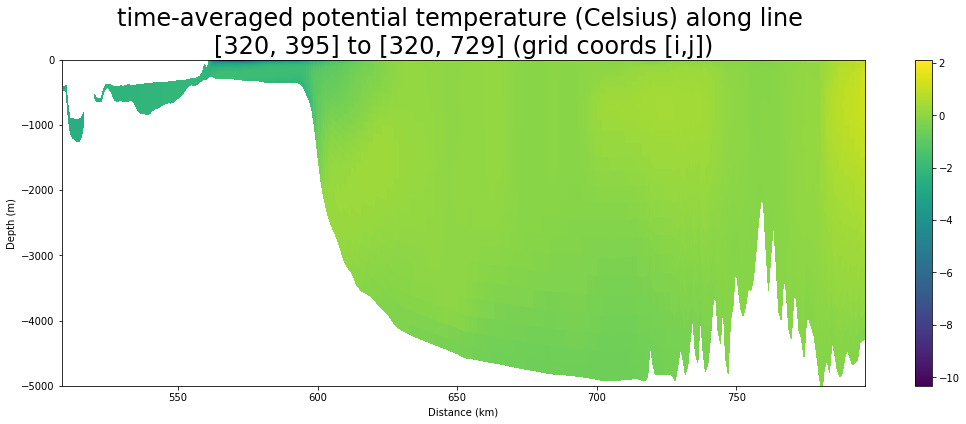

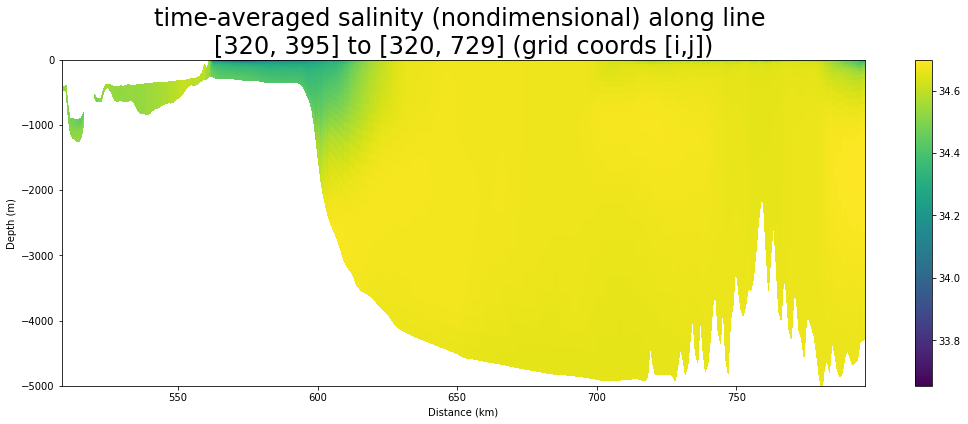

In [73]:
i_min,j_min,i_max,j_max=weddell[2:6]
plot_vslice.plot_vslice(path_l_avg,"temp",-5000,0,i_min,j_min,i_max,j_max,2,4,0.9,50,31)
plot_vslice.plot_vslice(path_l_avg,"salt",-5000,0,i_min,j_min,i_max,j_max,2,4,0.9,50,31)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


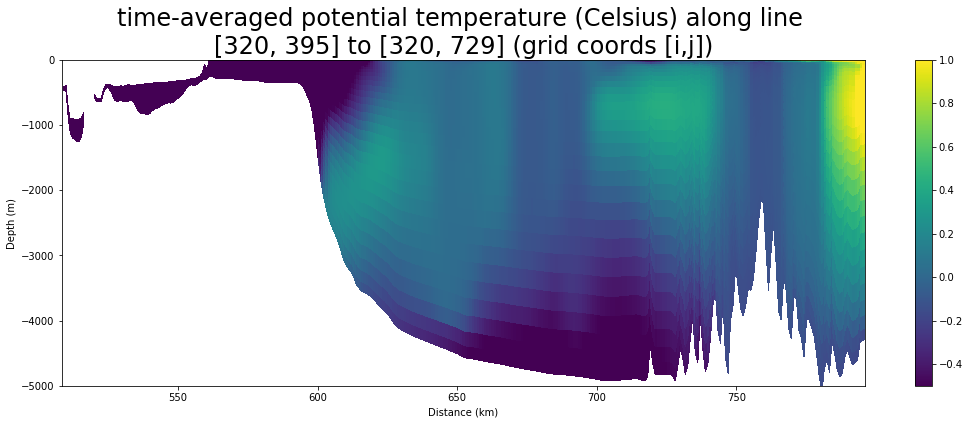

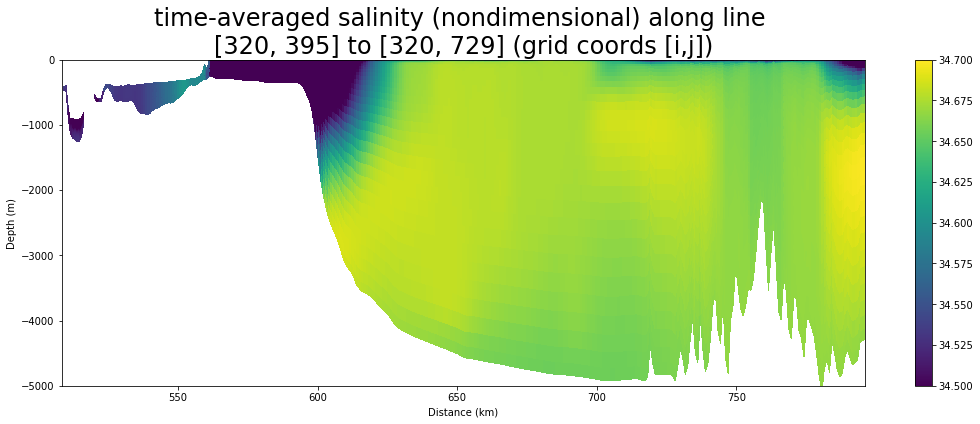

In [78]:
i_min,j_min,i_max,j_max=weddell[2:6]
plot_vslice.plot_vslice(path_l_avg,"temp",-0.5,1,-5000,0,i_min,j_min,i_max,j_max,2,4,0.9,50,31)
plot_vslice.plot_vslice(path_l_avg,"salt",34.5,34.7,-5000,0,i_min,j_min,i_max,j_max,2,4,0.9,50,31)

In [74]:
plot_vslice.plot_vslice?

### year widgets of vertical transsects of monthly averaged temperature and salinity

In [1]:
from sys import path
path.append('../toolBox/myTools/')
import tracer_evo_animation
import matplotlib.pyplot as plt
import netCDF4 as nc4
import numpy as np
import imp
imp.reload(tracer_evo_animation)

path_l_avg = '../data/raw/waom10_POT10/ocean_avg_0005.nc'

print("read in roms data ...")
id = nc4.Dataset(path_l_avg,'r')
mask_rho = id.variables['mask_rho'][:,:]
print('temp')
temp_rho = id.variables['temp'][:,:,:]
print('salt')
salt_rho = id.variables['salt'][:,:,:]
id.close()

read in roms data ...
temp
salt


In [6]:
trans = amery.copy()
tracer_evo_animation.tracer_evo_animation(path_l_avg,[path_l_avg],trans[0],trans[1],trans[2],trans[3],trans[4],trans[5])

Reading file: ../data/raw/waom10_POT10/ocean_avg_0005.nc
with 12 time records.
Getting amin and amax values of all times.
Building animation with 12 frames.


In [9]:
trans = weddell.copy()
tracer_evo_animation.tracer_evo_animation(path_l_avg,[path_l_avg],trans[0],trans[1],trans[2],trans[3],trans[4],trans[5])

Reading file: ../data/raw/waom10_POT10/ocean_avg_0005.nc
with 12 time records.
Getting amin and amax values of all times.
Building animation with 12 frames.


In [10]:
trans = drake.copy()
tracer_evo_animation.tracer_evo_animation(path_l_avg,[path_l_avg],trans[0],trans[1],trans[2],trans[3],trans[4],trans[5])

Reading file: ../data/raw/waom10_POT10/ocean_avg_0005.nc
with 12 time records.
Getting amin and amax values of all times.
Building animation with 12 frames.


In [11]:
trans = ross.copy()
tracer_evo_animation.tracer_evo_animation(path_l_avg,[path_l_avg],trans[0],trans[1],trans[2],trans[3],trans[4],trans[5])

Reading file: ../data/raw/waom10_POT10/ocean_avg_0005.nc
with 12 time records.
Getting amin and amax values of all times.
Building animation with 12 frames.
